In [ ]:
import google.generativeai as genai
import os

from dotenv import load_dotenv
load_dotenv()

KEY= os.environ["API_KEY"]

In [ ]:
genai.configure(api_key=KEY)

In [ ]:
from rich import print as rich_print
from rich.markdown import Markdown as rich_Markdown

## Text

In [ ]:
model = genai.GenerativeModel('gemini-pro')

response = model.generate_content("Write a story about a magic backpack.")
rich_print(response.text)

In [ ]:
# Additional Config to Set up the model
from google.generativeai.types import HarmCategory, HarmBlockThreshold, GenerationConfig

generation_config = GenerationConfig(
    temperature=1,
    max_output_tokens=8192,
)

safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}


model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

model_flash = genai.GenerativeModel(model_name="gemini-1.5-flash-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)
     

## Image

In [ ]:
from PIL import Image

image_filename = "croissant.jpg"
img = Image.open(image_filename)
img

In [ ]:
prompt = """
Describe this image, including which country is famous for having this food and what is the best pairing for it.
"""

response = model.generate_content([prompt, img])
print(response.text)

In [ ]:
rich_Markdown(response.text)

## Audio 


#### From an Interview of Elon Musk with CNBC ([Source](https://www.youtube.com/watch?v=6sUwRiIncKU&t=144s))
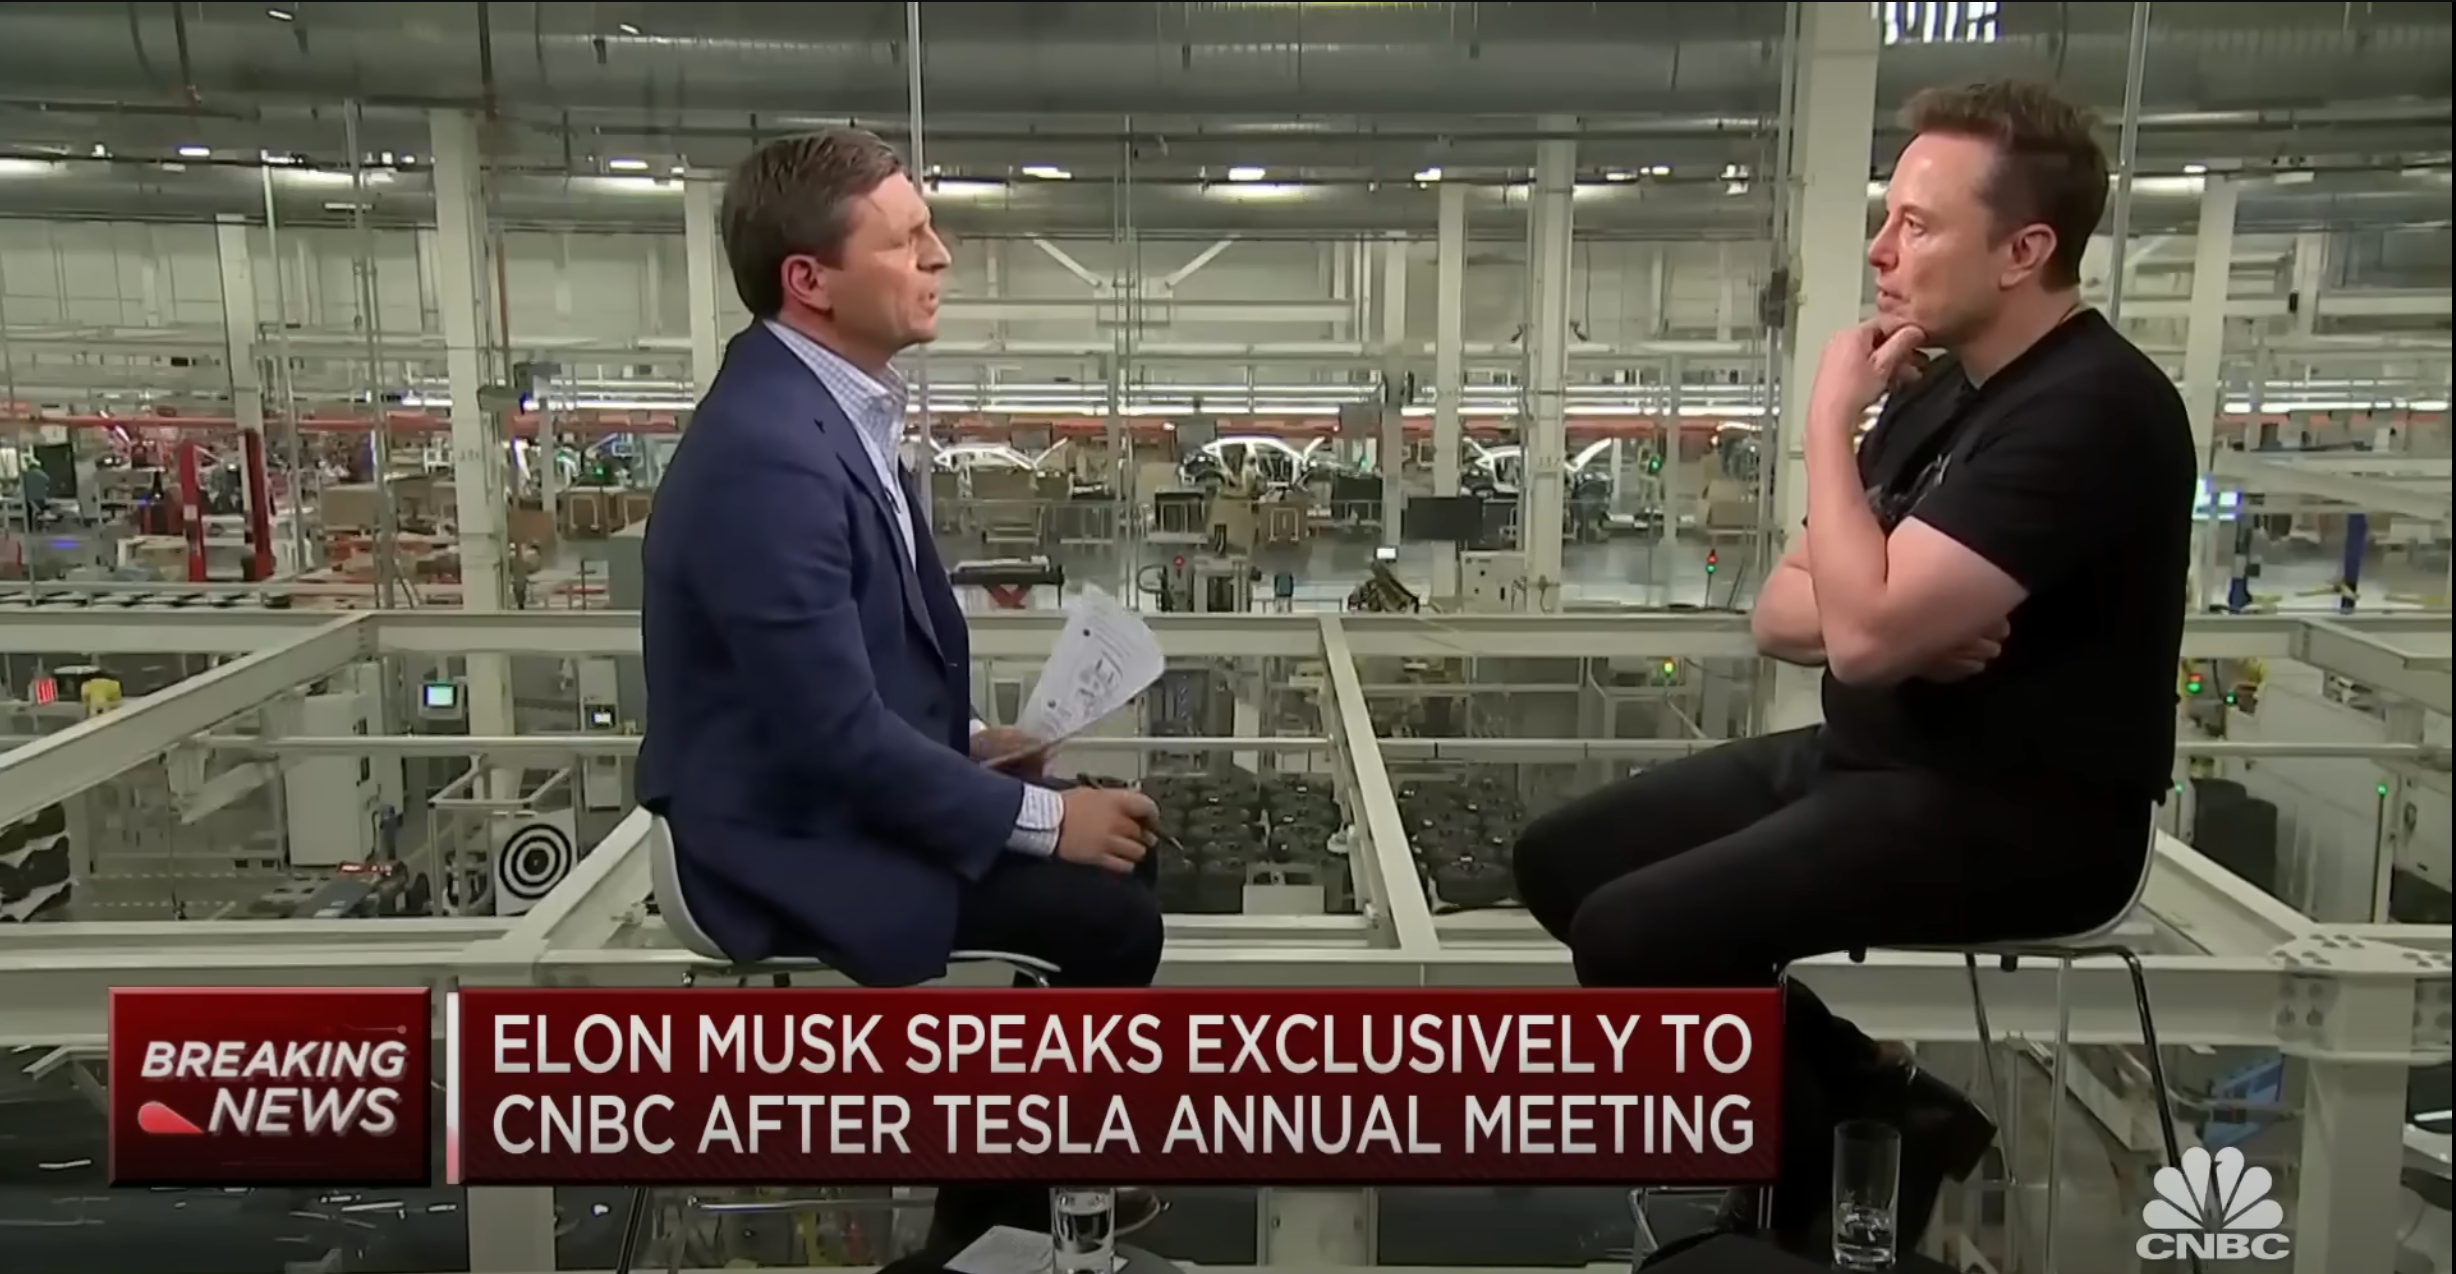

In [ ]:
from IPython.display import Audio

audio_filename= 'elonmusk_interview.wav'
Audio(audio_filename, autoplay=True)

### Audio Upload

In [ ]:
audio_file = genai.upload_file(path=audio_filename)

In [ ]:
prompt = "Listen carefully to the following audio file. Provide a brief summary."

model_flash = genai.GenerativeModel(model_name="models/gemini-1.5-flash")
response = model_flash.generate_content([prompt, audio_file])

rich_Markdown(response.text)

In [ ]:
model_pro = genai.GenerativeModel(model_name="models/gemini-1.5-pro")
response = model_pro.generate_content([prompt, audio_file], request_options={"timeout":600})

rich_print(response.text)

In [ ]:
# delete audio file
genai.delete_file(name=audio_file.name)

### Audio (Inline)

In [ ]:
from pydub import AudioSegment

sound = AudioSegment.from_wav(audio_filename)

In [ ]:
prompt =  "Please transcribe this recording:"
response = model.generate_content([
    prompt,
    {
        "mime_type": "audio/wave",
        "data": sound[:10_000].export().read() # 10 seconds
    }
])

In [ ]:
rich_print(response.text)

## Video

In [ ]:
# !wget https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4

In [ ]:
video_filename = "BigBuckBunny_320x180.mp4"

print(f"Uploading file...")
video_file = genai.upload_file(path=video_filename)
print(f"Completed upload: {video_file.uri}")

In [ ]:
prompt = "Describe and summarise the video"

# Make the LLM request.
print("Making LLM inference request...")
response = model_flash.generate_content(
    [prompt, video_file],
    request_options={"timeout": 600}
    )

rich_print(response.text)
     

In [ ]:
# Files are automatically deleted after 2 days or you can manually delete them 
genai.delete_file(video_file.name)
print(f'Deleted file {video_file.uri}')

## PDFs

In [ ]:
from pdf2image import convert_from_path

def pdf_to_images(file_path, output_folder="output_folder"):
    """Converts a PDF file into images for each page, saves them to a folder, and returns a list of image paths."""

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert PDF to images
    images = convert_from_path(file_path, dpi=200, output_folder=output_folder, fmt="jpg")

    # Generate image paths
    image_paths = []
    pages_list = []
    upload_file_name = []
    for i, image in enumerate(images):
        image_name = f"page_{i+1}.jpg"  # Page numbers start from 1
        image_path = os.path.join(output_folder, image_name)
        image.save(image_path, "JPEG")
        image_paths.append(image_path)
        files_to_upload = genai.upload_file(image_path, display_name=image_path)
        pages_list.append(files_to_upload)
        upload_file_name.append([files_to_upload.name, files_to_upload.display_name])

    return image_paths, pages_list, upload_file_name

def make_request(prompt, files):
  request = [prompt]
  for file in files:
    request.append(file)
  return request

def delete_files(output_folder):
  for filename in os.listdir(output_folder):
    if filename.endswith(".jpg"):
      file_path = os.path.join(output_folder, filename)
      genai.delete_file(name=file_path)
     

In [ ]:
pdf_path = "marathon_l1.pdf"
output_folder = "tmp/output_images"

image_paths, pages_list, upload_file_name = pdf_to_images(pdf_path, output_folder)

prompt = "How many weeks does the training plan cover?"

response = model.generate_content(
    make_request(prompt, pages_list),
    request_options={"timeout": 600}
    )

print(response.text)